In [1]:
import os
os.chdir('../src')

from molecular_cloud_initialization import *
from plotters import *
from cluster_cloud_initialization import *


import numpy as np
import matplotlib.pyplot as plt
from amuse.community.fi.interface import Fi
from amuse.lab import Particles, nbody_system
from amuse.couple import bridge
from amuse.units import units
from amuse.community.bhtree.interface import Bhtree
from amuse.ext.sink import new_sink_particles



In [2]:
tot_cloud_mass = 4/3 *units.constants.pi * (20 | units.pc)**3 * ( 2.3 | units.amu * 85 / (units.cm**3))
print(tot_cloud_mass.value_in(units.MSun))

#Assmuing a pure molecular hydrogen cloud, with typical density around 85 molecules per cm^-3, calculate the approximate cloud mass based on
#cloud size. 20 pc is selected for a tiny GC of only 100 stars. 

160697.345071


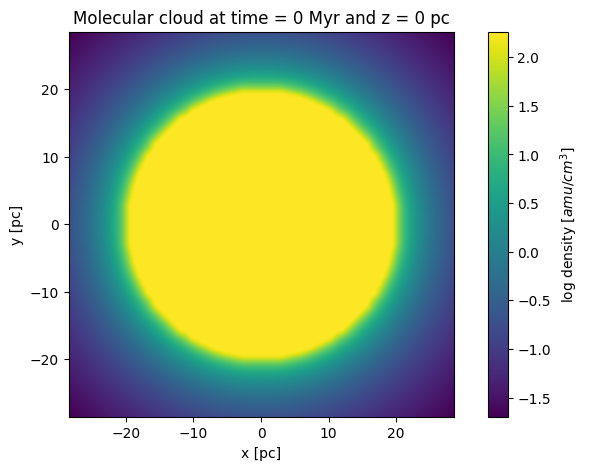

ready for evolution
Time 0.2 Myr
Time 0.4 Myr
Time 0.6 Myr
Time 0.8 Myr
Time 1.0 Myr
Time 1.2 Myr
Time 1.4 Myr
Time 1.6 Myr
Time 1.8 Myr
Time 2.0 Myr


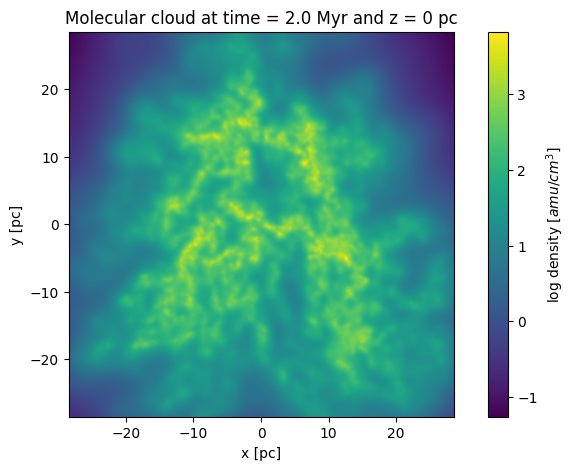

Average mass of a SPH particle 0.49891568990061824.


In [3]:
# initialise and evolve the MC particle set
particles_cloud, converter_cloud  = make_molecular_cloud(N_cloud = 300_000,
                                                         M_cloud = 150_000 | units.MSun,
                                                         R_cloud = 20 | units.pc,
                                                         seed = 1312)

particles_cloud, density_map = evolve_molecular_cloud(particles_cloud, 
                                         converter_cloud, 
                                         t_end = 2 | units.Myr, 
                                         dt = 0.2 | units.Myr, 
                                         seed = 1312)

In [4]:
def hydro_code(Code, dt, converter, particles, seed):
    '''
    This function contains the parameters we want to initialise the 
    hydro code with. (hard Coded)
    '''
    
    np.random.seed(seed)

    hydro = Code(converter)
    hydro.parameters.use_hydro_flag = True # Hydrodynamics flag. True means:
                            # SPH hydro included, False means: gravity only.
    hydro.parameters.gamma = 1 # gas polytropic index (1.6666667)
                        # (default value:1.6666667). In this case-> Ideal Gas   
    hydro.parameters.timestep = dt
    hydro.parameters.eps_is_h_flag = True # Default value
    hydro.parameters.radiation_flag = False # turns off radiatiative cooling/heat.
    hydro.parameters.isothermal_flag = True  # Isothermal flag. True means:
                # isothermal gas (requires integrate_entropy_flag == False)
    hydro.parameters.integrate_entropy_flag = False #True means: integrate
                                          # entropy, else: internal energy. 
    hydro.gas_particles.add_particles(particles) # add the particles
   
    return hydro    

In [5]:
np.mean(particles_cloud.density)

quantity<1.15657226466e-18 m**-3 * kg>

In [6]:
# initialise the star particle set
star = Particles(1)
star.name = "star"
star.mass = 0.7 |units.MSun
star.radius = 1 | units.RSun
star.position = (-1.0, 0, 0) * (22 | units.pc)
# star.velocity = (1.0, 0, 0) * (vorb.in_(units.kms))
star.velocity = (1.0, 0, 0) * (20| units.kms)

initial_mass = 0.7 |units.MSun
converter_star = nbody_system.nbody_to_si(star.mass.sum(), 
                                   star.position.sum())

In [7]:
#initiate the gravity code with sink particles
gravity_code = Bhtree(converter_star)
sink = new_sink_particles(star)

gravity_code.particles.add_particles(sink)

In [8]:
# #start the hydro code for the gas
hydro_cloud = hydro_code(Code = Fi, dt = 0.1 | units.Myr,
                         converter = converter_cloud,
                         particles = particles_cloud,
                         seed = 1312)


channel = {"to_sink": gravity_code.particles.new_channel_to(sink),
           "from_sink": sink.new_channel_to(gravity_code.particles),
           "to_cloud": hydro_cloud.gas_particles.new_channel_to(particles_cloud),
            "from_cloud": particles_cloud.new_channel_to(hydro_cloud.gas_particles)}



In [9]:
gravhydrobridge = bridge.Bridge(use_threading = False)
gravhydrobridge.add_system(gravity_code, (hydro_cloud,) )
gravhydrobridge.add_system(hydro_cloud, (gravity_code,) )
gravhydrobridge.timestep = 0.1 | units.Myr

In [10]:
# def sound_speed(temp,mean_molecular_mass):
#     temp = temp | units.K
#     k = units.constants.kB
#     molecular_weight = mean_molecular_mass | units.amu
#     sound_speed =(k*temp/molecular_weight).sqrt()

#     return sound_speed
    
    
def bondi_radius(stellar_mass):
    sound_speed = 0.2 | units.kms
    R = 2 * units.constants.G * stellar_mass /(sound_speed **2)

    return R

def bondi_accretion_rate(rho,v,r):
    dM = units.constants.pi * (r**2) * rho * v

    return dM


def hydro_sink_particles(sinks, bodies):
    all_lost_particles = Particles()
    for s in sinks:
        xs,ys,zs=s.x,s.y,s.z
        radius_squared = s.radius**2
        insink=bodies.select_array(lambda x,y,z: (x-xs)**2+(y-ys)**2+(z-zs)**2 < radius_squared,['x','y','z'])  
        if len(insink)==0:
            return insink

        cm=s.position*s.mass
        p=s.velocity*s.mass
        s.mass+=insink.total_mass()
        s.position=(cm+insink.center_of_mass()*insink.total_mass())/s.mass
        s.velocity=(p+insink.total_momentum())/s.mass
        all_lost_particles.add_particles(insink)
    return all_lost_particles


In [11]:
print(sink.mass[0]-initial_mass)

0.0 MSun


In [13]:
r = (bondi_radius(0.7 | units.MSun)).in_(units.pc)

bondi_accretion_rate(particles_cloud.density, 20 |units.kms, r)

0.150570272486


In [14]:
print(len(particles_cloud.mass))
print(particles_cloud.mass.sum().value_in(units.MSun))
print(sink.mass)

300652
150000.0
[0.7] MSun


In [17]:
t_end = 5 | units.Myr
model_time = 0 | units.Myr
dt = 0.3 | units.Myr

L = int(abs(sink.position.sum().value_in(units.pc)))*1.2
N = 100

total_mass_snapshots = []
accreted_mass_per_step = []


while model_time < t_end:

    sink.sink_radius = bondi_radius(0.5 | units.MSun)

    total_mass_snapshots.append(initial_mass)

    model_time += dt
    gravhydrobridge.evolve_model(model_time)

    # update channels
    channel["from_sink"].copy()
    channel["to_sink"].copy()
    channel["to_cloud"].copy()

    print('Sink in progress at', model_time.value_in(units.Myr), ' Myr')
    print('star x location at ', sink.x.in_(units.pc))
    
   
    #bondi_radius(sink.mass)
    sink.accrete(particles_cloud)

    total_mass_snapshots.append(sink[0].mass)
    dm = total_mass_snapshots[-1] - total_mass_snapshots[-2]
    accreted_mass_per_step.append(dm)

    print(dm)
    print(len(particles_cloud.mass), "number of cloud particles now")
    print("star mass post accretion",sink.mass[0])

    plt.scatter(sink.x.value_in(units.pc), sink.y.value_in(units.pc), c = 'red')
    plt.scatter(particles_cloud.x.value_in(units.pc), particles_cloud.y.value_in(units.pc), s = 1)
    plt.title("Molecular cloud at time = " + model_time.as_string_in(units.Myr))
    plt.xlabel("x [pc]")
    plt.ylabel("y [pc]")
    plt.show()

  


In [14]:
gravity_code.stop()
hydro_cloud.stop()
gravhydrobridge.stop()

In [15]:
print(sink.mass.value_in(units.MSun))
print(star.mass)

[ 686.52849741]
[686.528497409] MSun


In [23]:
print(particles_cloud.mass.sum().value_in(units.MSun)+186)

9999.47150259


In [17]:
star.mass = 2542 |units.MSun

In [18]:
print(sink.mass)

[2542.0] MSun
